## MCP Creator APP

### *Tabla de Contenido*

- Instalar e importar Dependencias

- Cargar documentos

- Transformar documentos

- Generador de incrustraciones de texto

- Vector store `PINECONE`

- Constestar `Retrieve`

- Estructurar el output

![mcq langchain.PNG](<attachment:mcq langchain.PNG>)
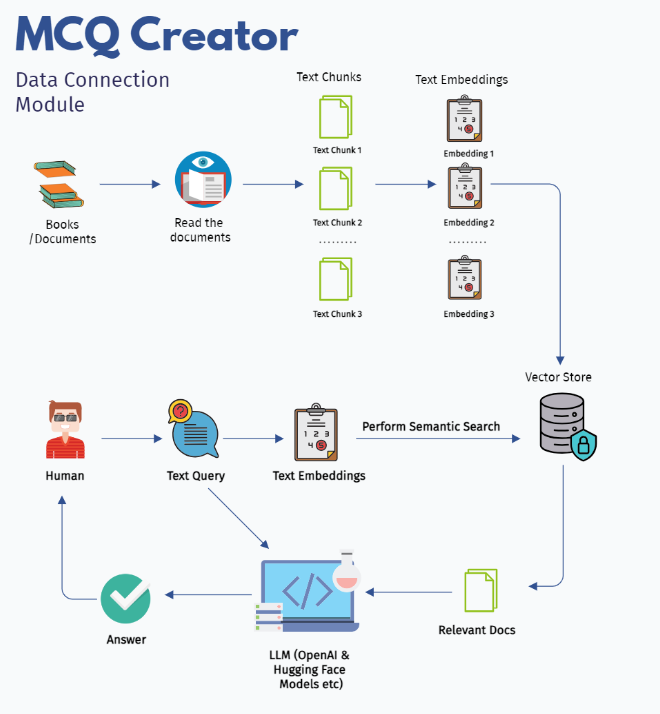

## 1. Librerías

In [214]:
# from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain.chat_models import init_chat_model

from langchain.document_loaders import PyPDFDirectoryLoader
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.text_splitter import RecursiveCharacterTextSplitter

from pinecone import Pinecone as PineconeClient

from typing import Annotated

from uuid import uuid4

## 2. Instanciar un Objeto de Modelo de Lenguaje de OpenAI (De Paga)

In [215]:
llm = init_chat_model('gpt-4o-mini', model_provider= 'openai', configurable_fields= {'temperature': 0, 'max_tokens': 100})

## 3. Modelo en Uso 

In [216]:
# llm.invoke([HumanMessage(content= 'Hola, mi nombre es Martin')])

## 4. Conexión de Datos

### *4.1. Cargar Documentos*

Carga archivos PDF disponibles en un directorio con `pypdf`.

In [217]:
# Crear una función que lea los documentos.
def cargar_docs(ruta_directorio: Annotated[str, 'Ruta del directorio que contiene los documentos']) -> Annotated[list, 'Lista de documentos']:   
    cargador = PyPDFDirectoryLoader(ruta_directorio)
    documentos = cargador.load()
    return documentos

In [218]:
# Pasando el directorio a la función.
ruta_directorio = 'document/'

documentos = cargar_docs(ruta_directorio)

len(documentos) # Cuenta por hojas.

2

In [219]:
documentos

[Document(metadata={'producer': 'iLovePDF', 'creator': 'PyPDF', 'creationdate': '', 'moddate': '2025-03-24T04:54:42+00:00', 'source': 'document/CV_MARTIN_REYES_parte_1.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content='MARTIN ABEL REYES ROJAS \nCallao, Lima| 934037573 | martin.reyes@unmsm.edu.pe | www.linkedin.com/in/martinreyesrojas \nportafolio: https://portafolio-e0hk2b498-martinabelrrs-projects.vercel.app/ \nPERFIL \nIngeniero de Sistemas y Ciencia de Datos apasionado por Machine Learning y desarrollo web full stack. \nClasificación en el 5% superior de mi clase. Especializado en la creación de soluciones de software \nescalables y eficientes, destacando en habilidades téc nicas y analíticas para abordar desafíos \ntecnológicos complejos.  \nHABILIDADES \n• Python (Librerías: Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn) – Avanzado. \n• Django – intermedio. \n• HTML5, CSS3, JavaScript – intermedio. \n• MySQL– Intermedio. \n• React – intermedio. \n \nEXPERIENCI

### *4.2. Dividir Documentos*

Dividir el documento en fragmentos más pequeños.

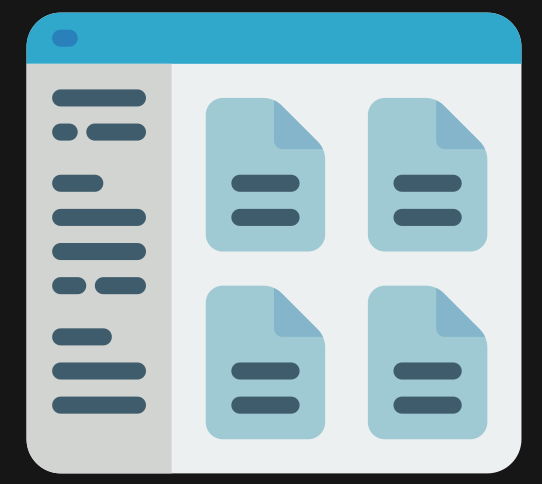

In [220]:
# Crear una función que divida los documentos en trozos.
def dividir_documentos(
        documentos: Annotated[list, 'Lista de documentos'], 
        tamaño_pedazo: Annotated[int, 'Tamaño de los pedazos'] = 500, 
        tamaño_superposición: Annotated[int, 'Tamaño de la superposición'] = 20) -> Annotated[list, 'Lista de documentos divididos']:
        divididor_texto = RecursiveCharacterTextSplitter(chunk_size= tamaño_pedazo, chunk_overlap= tamaño_superposición) 
        docs = divididor_texto.split_documents(documentos)
        return docs

In [221]:
documentos_dividos = dividir_documentos(documentos)

In [222]:
len(documentos_dividos)

8

### *4.3. Generador de Incrustraciones de Texto*

OpenAI LLM para crear incrustaciones para documentos/texto.

In [223]:
# incrustrador = OpenAIEmbeddings(model= 'ada')

HuggingFace LLM para crear incrustaciones para documentos/texto.

In [224]:
incrustador = HuggingFaceEmbeddings(model_name= 'all-MiniLM-L6-v2')

Probemos nuestro modelo de incrustaciones para un texto de muestra.

In [225]:
resultado_consulta = incrustador.embed_query("Hola Martin")
len(resultado_consulta) 

384

In [226]:
resultado_consulta

[-0.05035579949617386,
 0.10173474997282028,
 -0.054174188524484634,
 0.04007052257657051,
 -0.035463377833366394,
 0.0006051085074432194,
 0.11728884279727936,
 -0.006160816643387079,
 0.03633725270628929,
 0.06475472450256348,
 -0.043145857751369476,
 -0.01485308539122343,
 -0.08112289756536484,
 -0.07049688696861267,
 -0.019828269258141518,
 0.037491559982299805,
 -0.015226583927869797,
 0.036480046808719635,
 -0.02834456041455269,
 -0.004339269828051329,
 -0.04604727402329445,
 -0.005478461738675833,
 -0.07080840319395065,
 0.03973105922341347,
 -0.0024025184102356434,
 0.02429475635290146,
 0.0006663629901595414,
 0.09999999403953552,
 -0.047392260283231735,
 -0.057355575263500214,
 0.002060825005173683,
 -0.06091504171490669,
 0.008746263571083546,
 0.014706195332109928,
 -0.0726461336016655,
 -0.02138577774167061,
 -0.035527121275663376,
 -0.07939682900905609,
 0.05658162012696266,
 0.02238948829472065,
 0.05288664251565933,
 -0.0366133376955986,
 -0.06774894893169403,
 0.032221

### *4.4. Vector Store - PINECONE* 

- `Pinecone` permite cargar datos en una `base de datos vectorial` y realizar una verdadera búsqueda semántica. 

- Los datos conversacionales no solo son muy desestructurados, sino que también pueden ser complejos. La búsqueda vectorial y las bases de datos vectoriales permiten realizar búsquedas por similitud.

- Inicializaremos `Pinecone` y crearemos un índice de Pinecone pasando nuestros documentos, el modelo de incrustaciones y mencionando el índice específico  que se debe utilizar.

- Las `bases de datos vectoriales` están diseñadas para gestionar la estructura única de las incrustaciones vectoriales, que son vectores densos de números que representan texto. 

- Se utilizan en aprendizaje automático para capturar el significado de las palabras y mapear su significado semántico.

- Estas bases de datos indexan vectores para facilitar la búsqueda y recuperación comparando valores y encontrando aquellos que son más similares entre sí, lo que las hace ideales para el procesamiento del lenguaje natural y las aplicaciones impulsadas por IA.

In [ ]:
pc = PineconeClient(api_key= 'pcsk_W3Snq_BApRmVFtDqgvJpFUDP4ehy8jNQmdP8jjNipa2Gwww75pxvr9gx2UsHuAQprZFTc')

indice_nombre = 'vectorstore'

index = pc.Index(indice_nombre)

In [228]:
vector_store = PineconeVectorStore(
    index= index,
    embedding= incrustador
)

In [229]:
uuids = [str(uuid4()) for _ in range(len(documentos_dividos))]

vector_store.add_documents(
    documents= documentos_dividos,
    kwargs= {
        'ids': uuids
    }
)

['cb91be6a-cfaf-47c0-a28d-4a82626b15d0',
 'ea62612d-2bd9-40fe-a4ae-fc1292156f20',
 '0724a433-906e-47c4-b2f3-3967f1a5731f',
 '92d8d044-ed5d-46fb-9a3d-20ad1b7e1bc9',
 '291d1ff5-69e8-4fa0-a20a-21da08ff36f5',
 'd261637a-c10f-4f86-93b9-dd1a729c46d9',
 '4ec9f0ba-7e6f-4317-8919-b11cd2187b1e',
 '18bc02b1-a338-4959-a931-9901393a49aa']

### *4.5. Recuperar Respuesta (Retrieve Answers)*

In [230]:
# Esta función nos ayudará a obtener los mejores documentos relevantes de nuestra tienda de vectores - Pinecone.
def get_documentos_similares(
        query: Annotated[str, 'Consulta'], 
        k: Annotated[int, 'Número de documentos relevantes'] = 2) -> Annotated[list, 'Lista de documentos relevantes']:
    documentos_similares = vector_store.similarity_search(query, k= k)
    return documentos_similares

`load_qa_chain` Carga una cadena que puede usar para hacer QA sobre un conjunto de documentos.

Y usaremos Huggingface para el propósito del razonamiento.

In [231]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEndpoint

`BigScience Large Open-science Open-access Multilingual Language Model` (BLOOM) es un modelo de lenguaje grande basado en transformadores.

Fue creado por más de 1000 investigadores de IA para proporcionar un modelo de lenguaje grande gratuito para todos los que quieran probarlo. Entrenado en alrededor de 366 mil millones de tokens durante marzo hasta julio de 2022, se considera una alternativa al GPT-3 de OpenAI con sus 176 mil millones de parámetros.

In [232]:
# llm = HuggingFaceEndpoint(repo_id= 'bigscience/bloom', temperature= 1e-10)

In [233]:
# llm

Diferentes Tipos de **Cadena Tipo**:


- `map_reduce`: Divide los textos en lotes, procesa cada lote por separado con la pregunta y combina las respuestas para proporcionar la respuesta final.

- `refine`: Divide los textos en lotes y refina la respuesta procesando secuencialmente cada lote con la respuesta anterior.

- `map-rerank`: Divide los textos en lotes, evalúa la calidad de cada respuesta de LLM y selecciona las respuestas de mayor puntuación de los lotes para generar la respuesta final. Estas alternativas ayudan a manejar las limitaciones de los tokens y mejoran la efectividad del proceso de respuesta a preguntas.

In [234]:
indicacion = ChatPromptTemplate.from_template('A partir de este contenido: {context} responde a la consulta: {pregunta}')   
cadena = create_stuff_documents_chain(llm, indicacion) # Considera toda la información de la consulta.

In [235]:
# Esta función nos ayudará a obtener la respuesta a la pregunta que planteamos.
def get_respuesta(consulta: Annotated[str, 'Consulta']) -> Annotated[str, 'Respuesta']:
    documentos_similares = get_documentos_similares(consulta)
    print(f"Documentos similares: {documentos_similares}")
    respuesta = cadena.invoke({'context': documentos_similares, 'pregunta': consulta})

    return respuesta

In [236]:
nuestra_pregunta = 'correo de Martin Abel Reyes Rojas'

respuesta = get_respuesta(nuestra_pregunta)

print(f"Respuesta: {respuesta}")

Documentos similares: [Document(id='a5ecbb8b-48f1-49fd-adda-e04532080e9f', metadata={'creationdate': '', 'creator': 'PyPDF', 'moddate': '2025-03-24T04:54:42+00:00', 'page': 0.0, 'page_label': '1', 'producer': 'iLovePDF', 'source': 'document/CV_MARTIN_REYES_parte_1.pdf', 'total_pages': 1.0}, page_content='MARTIN ABEL REYES ROJAS \nCallao, Lima| 934037573 | martin.reyes@unmsm.edu.pe | www.linkedin.com/in/martinreyesrojas \nportafolio: https://portafolio-e0hk2b498-martinabelrrs-projects.vercel.app/ \nPERFIL \nIngeniero de Sistemas y Ciencia de Datos apasionado por Machine Learning y desarrollo web full stack. \nClasificación en el 5% superior de mi clase. Especializado en la creación de soluciones de software'), Document(id='7a30b7fd-82d3-4f67-b24f-b50872b985b0', metadata={'creationdate': '', 'creator': 'PyPDF', 'moddate': '2025-03-24T04:54:42+00:00', 'page': 0.0, 'page_label': '1', 'producer': 'iLovePDF', 'source': 'document/CV_MARTIN_REYES_parte_1.pdf', 'total_pages': 1.0}, page_content

### *4.6. Estructurar la Salida*

In [237]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI

import re
import json


In [238]:
esquema_respuesta = [
    ResponseSchema(name= 'pregunta', description= 'Pregunta generada a partir de los datos de texto de entrada proporcionados.'),
    ResponseSchema(name= 'opciones', description= 'Opciones disponibles para una pregunta de opción múltiple en coma separada.'),
    ResponseSchema(name= 'respuesta', description= 'Respuesta correcta para la pregunta formulada.'),
]

In [239]:
analizador_salida = StructuredOutputParser.from_response_schemas(esquema_respuesta)
analizador_salida

StructuredOutputParser(response_schemas=[ResponseSchema(name='pregunta', description='Pregunta generada a partir de los datos de texto de entrada proporcionados.', type='string'), ResponseSchema(name='opciones', description='Opciones disponibles para una pregunta de opción múltiple en coma separada.', type='string'), ResponseSchema(name='respuesta', description='Respuesta correcta para la pregunta formulada.', type='string')])

In [240]:
# Esto nos ayuda a obtener las instrucciones que el langchain crea para obtener la respuesta en el formato deseado.
formato_instrucciones = analizador_salida.get_format_instructions()
print(formato_instrucciones)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"pregunta": string  // Pregunta generada a partir de los datos de texto de entrada proporcionados.
	"opciones": string  // Opciones disponibles para una pregunta de opción múltiple en coma separada.
	"respuesta": string  // Respuesta correcta para la pregunta formulada.
}
```


In [241]:
# Instanciar el modelo de lenguaje.
llm = ChatOpenAI(
    model= 'gpt-4o-mini',
    temperature= 0.5,
    max_tokens= 100
)

In [242]:
# El siguiente fragmento dará una cadena que contiene instrucciones sobre cómo se debe formatear la respuesta, y luego la insertaremos en nuestro mensaje.
indicacion = ChatPromptTemplate(
    messages= [
        HumanMessagePromptTemplate.from_template('Cuando el usuario proporciona una entrada de texto, genere preguntas de opción múltiple de ello junto con la respuesta correcta.\n{formato_instrucciones}\n{indicacion_usuario}')
    ],
    input_variables= ['indicacion_usuario'],
    partial_variables= {'formato_instrucciones': formato_instrucciones}
)

In [243]:
consulta_final = indicacion.format_prompt(indicacion_usuario= respuesta)
print(consulta_final)

messages=[HumanMessage(content='Cuando el usuario proporciona una entrada de texto, genere preguntas de opción múltiple de ello junto con la respuesta correcta.\nThe output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"pregunta": string  // Pregunta generada a partir de los datos de texto de entrada proporcionados.\n\t"opciones": string  // Opciones disponibles para una pregunta de opción múltiple en coma separada.\n\t"respuesta": string  // Respuesta correcta para la pregunta formulada.\n}\n```\nEl correo de Martin Abel Reyes Rojas es: martin.reyes@unmsm.edu.pe.', additional_kwargs={}, response_metadata={})]


In [244]:
consulta_final.to_messages()

[HumanMessage(content='Cuando el usuario proporciona una entrada de texto, genere preguntas de opción múltiple de ello junto con la respuesta correcta.\nThe output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"pregunta": string  // Pregunta generada a partir de los datos de texto de entrada proporcionados.\n\t"opciones": string  // Opciones disponibles para una pregunta de opción múltiple en coma separada.\n\t"respuesta": string  // Respuesta correcta para la pregunta formulada.\n}\n```\nEl correo de Martin Abel Reyes Rojas es: martin.reyes@unmsm.edu.pe.', additional_kwargs={}, response_metadata={})]

In [245]:
consulta_final_output = llm.invoke(consulta_final.to_messages())
consulta_final_output

AIMessage(content='```json\n{\n\t"pregunta": "¿Cuál es el correo electrónico de Martin Abel Reyes Rojas?",\n\t"opciones": "martin.reyes@unmsm.edu.pe, martin.abel@unmsm.edu.pe, abel.reyes@unmsm.edu.pe, martin.reyes@gmail.com",\n\t"respuesta": "martin.reyes@unmsm.edu.pe"\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 147, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLO7JYOtiMl4wjhaXxxZxRRJwZhQK', 'finish_reason': 'stop', 'logprobs': None}, id='run-8a24b43b-9883-44a0-a4f9-1163f340c944-0', usage_metadata={'input_tokens': 147, 'output_tokens': 86, 'total_tokens': 233, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details

Mientras trabajamos con escenarios como el anterior, donde tenemos que procesar cadenas de varias líneas(separadas por caracteres de nueva línea – ‘\n’). En tales situaciones, utilizamos `re`.

In [246]:
texto_markdown = consulta_final_output.content
string_json = re.search(r'{(.*?)}', texto_markdown, re.DOTALL).group(1)

In [247]:
print(string_json)


	"pregunta": "¿Cuál es el correo electrónico de Martin Abel Reyes Rojas?",
	"opciones": "martin.reyes@unmsm.edu.pe, martin.abel@unmsm.edu.pe, abel.reyes@unmsm.edu.pe, martin.reyes@gmail.com",
	"respuesta": "martin.reyes@unmsm.edu.pe"

